# Mathematical Model for Natural Language

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using SparseArrays

#statistics
using Random
using StatsBase
using Statistics
using Distributions

#dataframe
using DataFrames

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

# Part1: Create Network and data<hr>

## 1. Barabási-Albert Network and Random walk on it

In [2]:
#normalize
function normalize(vec)
    S = sum(vec)
    if S>0
        return vec/sum(vec)
    else
        vec[1] = 1
        return vec
    end
end
    
#initialize the graph
function initialize!(adj,m)
    for j in 1:m
       for k in j+1:m
            adj[k,j] = 1
            adj[j,k] = 1
        end
    end
end

#choose m nodes
function choose_nodes(adj,m)
    probs = normalize(sum(adj,dims=2)[:])
    return rand(Categorical(probs),m)
end

#update adjacency matrix
function update_adj!(adj,nodes,v)
    adj[nodes,v] = ones(Int64,m)
    adj[v,nodes] = ones(Int64,m)
end

#V nodes each of which has m edges
function BAmodel(m,V)
    adj = spzeros(Int64,V,V)
    nodes = zeros(Int64,m)
    initialize!(adj,m)
    @showprogress for v in m+1:V
        nodes = choose_nodes(adj,m)
        update_adj!(adj,nodes,v)
    end
    return adj
end

#choose the next node
function walk(current_node,adj,edges)
    nodes = adj[:,current_node].nzind
    probs = normalize(edges[nodes])
    idx = rand(Categorical(probs))
    return nodes[idx]
end

#random walk
function myRW(adj,m,V,N)
    edges = sum(adj,dims=2)[:]
    current_node = 1#rand(1:V)
    path = zeros(Int64,N)
    path[1] = current_node
    @showprogress for n in 2:N
        current_node = walk(current_node,adj,edges)
        path[n] = current_node
    end
    return path
end

myRW (generic function with 1 method)

## 2. Create data

In [3]:
#set the random seed
Random.seed!(42)

#create the BA network
m = 1
V = Int(1e5)
adj = BAmodel(m,V)

#create word sequence
N = Int(1e6)
W = myRW(adj,m,V,N)
n_unique = length(unique(W))

#data
data = (W=W,V=V,N=N,n_unique=n_unique)
println("The number of vocabrary = $(V). ")
println("The document has $(N) words in total. ")
println("The document has $(n_unique) unique words in total. ")

Progress: 100%|█████████████████████████████████████████| Time: 0:13:45
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


The number of vocabrary = 100000. 
The document has 1000000 words in total. 
The document has 41936 unique words in total. 


# Part2: Statistical Universals<hr>

## 3. Define functions

In [4]:
#linear regression of log-log plot
function loglinreg(X,Y)
    log10X = log10.(X)
    log10Y = log10.(Y)
    meanX = mean(log10X)
    meanY = mean(log10Y)
    a = cov(log10X,log10Y,corrected=false)/var(log10X,corrected=false)
    b = mean(log10Y)-a*mean(log10X)
    return a,b
end
loglinreg(Y) = loglinreg(collect(1:length(Y)),Y)

#word dataframe
word_df(W) = DataFrame(word_id=W)

#word frequency dataframe(sorted)
function word_freq_df(df)
    word_cnt_df = combine(nrow,groupby(df,:word_id))
    return sort(word_cnt_df,:nrow,rev=:true)
end

#unify rare wards lowest 1/Ψ
function unify_rare_words(data,my_word_freq_df,Ψ)
    @unpack W,N,V,n_unique = data
    Wrare = zeros(Int64,N)
    rare_word_id = maximum(W)+1
    sorted_freqs = sort(my_word_freq_df,:nrow)
    rare_words = sorted_freqs[cumsum(sorted_freqs.nrow) .< Int(floor(N/Ψ)),:].word_id
    for n in 1:N
        if W[n] in rare_words
            Wrare[n] = rare_word_id
        end
    end
    return Wrare, rare_word_id
end

#interval sequence for a specific word
function Qv_df(W,v)
    is_v_idx = SparseVector(W.==v).nzind
    Qv = is_v_idx[begin+1:end] - is_v_idx[begin:end-1]
    df = DataFrame(Qv=Qv)
    freq_df = combine(nrow,groupby(df,:Qv))
    return df, sort(freq_df,:nrow)
end

"""
Statistical Universal 1: Zipf's Law: 
"""
#linear regression for Zipf's law
function loglinreg(X,Y,max_rel_freq::Float64)
    log10X = log10.(X)
    log10Y = log10.(Y)
    log10_max_rel_freq = log10(max_rel_freq)
    a = (sum(log10X.*log10Y)-log10_max_rel_freq*sum(log10X))/sum(log10X.^2)
    return a,log10_max_rel_freq
end
loglinreg(Y,max_rel_freq::Float64) = loglinreg(collect(1:length(Y)),Y,max_rel_freq)

"""
Statistical Universal 2: Vocabulary Growth
"""
#vocabulary growth
function vacab_growth(data,Δ)
    @unpack W,N = data
    n_uniq_words = zeros(div(N,Δ))
    @showprogress for n in 1:div(N,Δ)
        n_uniq_words[n] = length(unique(W[1:n*Δ]))
    end
    return n_uniq_words
end

"""
Statistical Universal 3: Excess Probability: 
"""
#cumulative distribution lower than q
cumv(q,Qv_freq_df) = sum(Qv_freq_df[Qv_freq_df.Qv.<=q,:].nrow)
function cumvvec(qs,W,v)
    freq_v = sum(W.==v)
    n_qs = length(qs)
    cums = zeros(n_qs)
    _, Qv_freq_df = Qv_df(W,v)
    @showprogress for j in 1:n_qs
        cums[j] = cumv(qs[j],Qv_freq_df)
    end
    return cums/(freq_v-1)
end

function excess_prob(words,rare_words,qs)
    @unpack N = data
    @unpack W_rare,rare_word_id,rare_words_freq = rare_words
    λv = N/rare_words_freq
    return 1 .- cumvvec(λv*qs,W_rare,rare_word_id)
end

"""
Statistical Universal 4: Autocorrelation: 
"""
#autocorrelation
function my_autocorr(X,lags)
    n_lags = length(lags)
    acfs = zeros(n_lags)
    meanX = mean(X)
    varX = var(X,corrected=false)
    for i in 1:n_lags
        acfs[i] = dot(X[1:end-lags[i]].-meanX,X[1+lags[i]:end].-meanX) / (length(X)-lags[i])
    end
    return acfs / varX
end

"""
Statistical Universal 5: Taylor Analysis: 
"""
#count words in the partial sequence length l
function interval_freq_count(Q,N,l)
    freq = sum(0 .< Q .≤ l); freqs = zeros(Int64,N-l+1)
    idx_right = argmax(l .<= Q); idx_left = 1
    qr = Q[idx_right]; ql = Q[idx_left]
    for r in l:N
        freqs[r-l+1] = freq
        #update right
        if r == qr
            freq += 1
            freqs[r-l+1] = freq
            idx_right += 1
            qr = Q[idx_right]
        end
        #update left
        if r-l+1 == ql
            freq -= 1
            idx_left += 1
            ql = Q[idx_left]
        end
    end
    return freqs
end

#mean and standard deviations of the frequencies of all words in the partial sequence length l
function interval_freqs(data,l)
    @unpack W,N,n_unique = data
    vocabs = unique(W)
    freqs = zeros(Int64,N-l+1)
    means = zeros(n_unique)
    stds = zeros(n_unique)
    @showprogress for i in 1:n_unique
        v = vocabs[i]
        is_v_idx = findall(x->x==v,W)
        push!(is_v_idx,0)
        freqs = interval_freq_count(is_v_idx,N,l)
        means[i] = mean(freqs)
        stds[i] = std(freqs)
    end
    return means,stds
end

interval_freqs (generic function with 1 method)

## 4. word frequency and rare words interval

In [5]:
#frequency
my_word_df = word_df(W)
my_word_freq_df = word_freq_df(my_word_df)

#rare words interval
Random.seed!(42)
Ψ = 16
W_rare, rare_word_id = unify_rare_words(data,my_word_freq_df,Ψ)
my_Q_df, _ = Qv_df(W_rare,rare_word_id)
Qv = my_Q_df.Qv
rare_words_freq = sum(W_rare.!=0)
rare_words = (Ψ=Ψ,W_rare=W_rare,Qv=Qv,rare_words_freq=rare_words_freq,rare_word_id=rare_word_id)

(Ψ = 16, W_rare = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Qv = [2, 3, 1, 1, 1, 1, 2, 11, 2, 36  …  2, 4, 5, 4, 4, 2, 4, 5, 2, 5], rare_words_freq = 62499, rare_word_id = 99999)

## 5. Verify the Statistical Universals

## `Statistical Universal 1: Zipf's Law`

slope = -1.120353027466318


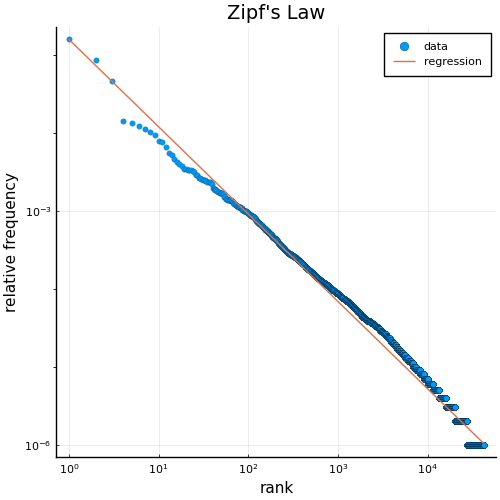

In [6]:
sorted_rel_freqs = reverse(sort(my_word_freq_df.nrow))/N
a,b = loglinreg(sorted_rel_freqs,sorted_rel_freqs[1])
println("slope = $(a)")
fig1 = plot(sorted_rel_freqs,st=:scatter,xscale=:log10,yscale=:log10,markerstrokewidth=0.1,
    title="Zipf's Law",xlabel="rank",ylabel="relative frequency",label="data",size=(500,500))
plot!(r->(10^b*r^a),label="regression")

## `Statistical Universal 2: Vocabulary Growth`

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


slope = 0.6013947515566809


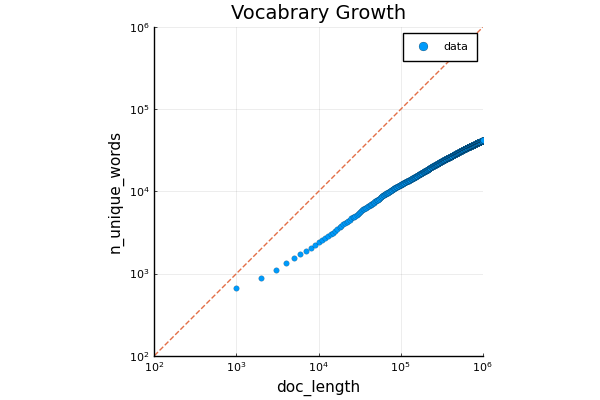

In [7]:
Δ = Int(1e3)
n_uniq_words = vacab_growth(data,Δ)
a,b = loglinreg(n_uniq_words)
println("slope = $(a)")
fig2 = plot(1:Δ:N,n_uniq_words,st=:scatter,xscale=:log10,yscale=:log10,markerstrokewidth=0.1,xlim=(1e2,N),ylim=(1e2,N),
    title="Vocabrary Growth",xlabel="doc_length",ylabel="n_unique_words",label="data",aspect_ratio=:equal)
plot!(x->x,ls=:dash,label=false)

## `Statistical Universal 3: Excess Probability`

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


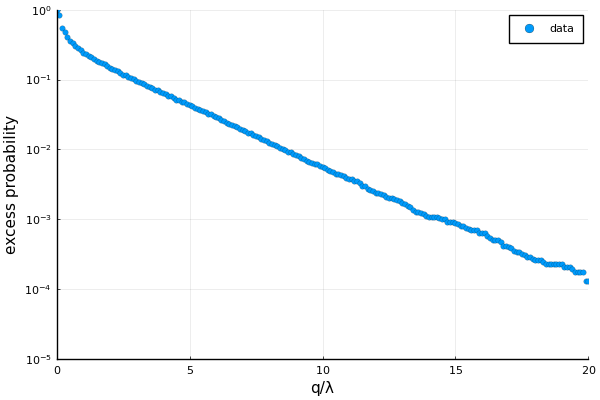

In [8]:
qs = 0:0.1:20
excess_probs = excess_prob(data,rare_words,qs)
fig3 = plot(qs,excess_probs,yscale=:log10,st=:scatter,markerstrokewidth=0.1,label="data",
    xlabel="q/λ",ylabel="excess probability",xlim=(0,20),ylim=(1e-5,1e0))

## `Statistical Universal 4: Autocorrelation`

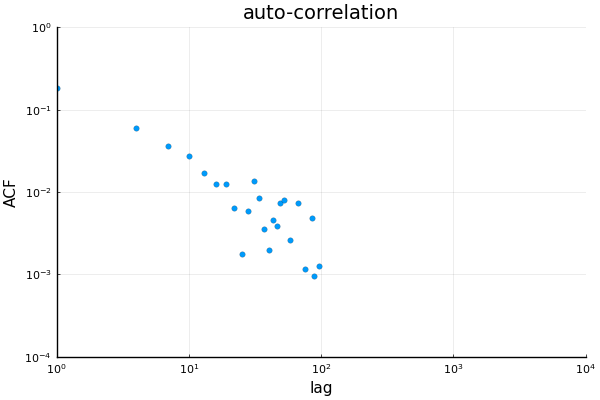

In [9]:
lags = 1:3:100
acf_vec = my_autocorr(Qv,lags)
fig4 = plot(lags,acf_vec,st=:scatter,markerstrokewidth=0.1,xlabel="lag",ylabel="ACF",title="auto-correlation",
    label=false,xscale=:log10,yscale=:log10,xlim=(1e0,1e4),ylim=(1e-4,1e0))

## `Statistical Universal 5: Taylor Analysis`

Progress: 100%|█████████████████████████████████████████| Time: 0:04:13


slope = 0.6080208113881345


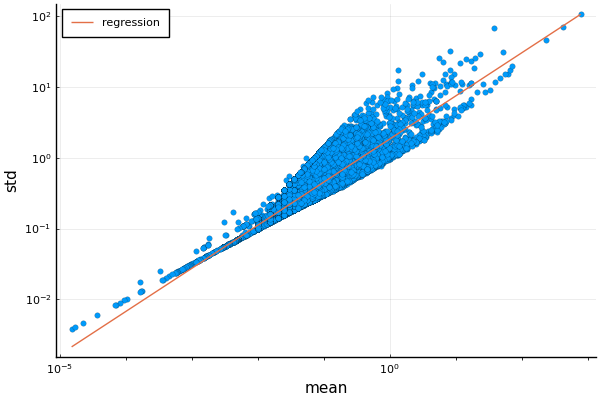

In [10]:
l = 5000
means,stds = interval_freqs(data,l)
a,b = loglinreg(means,stds)
println("slope = $(a)")
fig5 = plot(means,stds,st=:scatter,markerstrokewidth=0.1,xscale=:log10,yscale=:log10,label=false)
plot!(x->(10^b*x^a),label="regression",legend=:topleft,xlabel="mean",ylabel="std")